# Testing out DNA-BERT2 with a fake and very simple dataset
To start, I will fine-tune DNABERT2 to be able to classify sequences. Eventually, I'd be able to see if it can capture the p53 (transcription factor) motif in dna regions differentially transcribed in response to p53 activation (via Nutlin). However, this would include like 10k regions. Therefore, I will start with a fake dataset where 1 classification indicates a long stretch of GC.

**Warning:** The installation/environment process is the most annoying part. Make sure you are using python 3.8. My full environment list is at the bottom of this notebook

In [4]:
# =============================
#  1. Install necessary libraries
# =============================
!pip install transformers datasets torch scikit-learn
!pip install shap
!pip install matplotlib

# =============================
#  2. Import Libraries
# =============================
import matplotlib
import torch
import pickle
import pandas as pd
import random
import shap
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## 1. Create the toy dataset
* I create a dataset where class 1 = long stretch of GC and class 0 = not. I create 30 sequences of length 30 here.

In [5]:
# Generate random sequences with the specified content "GCGC" stretch for "on" sequences
def generate_sequence(length=30, on=False):
    if on:
        # Create a sequence with a long "GCGC" stretch
        sequence = "GCGC" * (length // 4) + ''.join(random.choices('ATGC', k=length - len("GCGC" * (length // 4))))
    else:
        # Create a random sequence without "GCGC" stretch
        sequence = ''.join(random.choices('ATGC', k=length))
    return sequence

# Generate sequences
sequences = []
labels = []
for i in range(30):
    # Randomly decide whether the sequence should have the "on" feature
    on = random.choice([True, False])
    sequences.append(generate_sequence(on=on))
    labels.append(1 if on else 0)

In [23]:
df = pd.DataFrame({"sequence": sequences, "label": labels})
df

,sequence,label
0,GCGCGCGCGCGCGCGCGCGCGCGCGCGCAT,1
1,GCGCGCGCGCGCGCGCGCGCGCGCGCGCAA,1
2,GCGCGCGCGCGCGCGCGCGCGCGCGCGCGA,1
3,GCGCGCGCGCGCGCGCGCGCGCGCGCGCAG,1
4,GCGCGCGCGCGCGCGCGCGCGCGCGCGCGG,1
5,AGCACGTACTAACGCGGCTGCGCGGAATAA,0
6,GCGCGCGCGCGCGCGCGCGCGCGCGCGCTT,1
7,ATGGGAGGATTCGATCACCTACGGATCGAA,0
8,GTGTCATCCAAGGTGTTGCGACCCTTAAGG,0
9,GCGCGCGCGCGCGCGCGCGCGCGCGCGCGA,1


## 2. Get Fine-tuning ready
#### Why?
The BERT model is not specifically trained to answer my question of interest. Therefore, the authors recommend I download the model and **fine-tune** it to work for my question of interest. That means I take the model that has its parameters mostly optimized by using a HUGE training set. Then I can just fine-tune the parameters to be *even better* for my question by training the model on my specific question.
#### What is the code doing?
1. Train_test_split allows the sequences to be split into a training and validation set. Training set is what is used to train the model. Validation set is what is used to assess how well the trained model is doing.
2. Tokenizing the datasets
    - We use the DNABERT-2-117M to tokenize the sequences based on their pretrained model. Tokenization means that the sequences can be converted to numerical values that therefore can be used in the math of a classifier. The significance of using DNABERT-2 for this is that it has been pretrained to be able to encode sequence into token values that are informative of a sequence's functional properties.
3. Defining Training Arguments
    - This is NOT DNABERT specific but instead is simply using the transformers package to prepare arguments for training a model
    - epoch is like a trial for the model. The model considers every data point in the training dataset through the training algorithm. Since we have evaluation_strategy at epoch, the model will update its parameters after each epoch to hopefully perofrm better on the next epoch.
4. Define Trainer
   - Now that we have training arguments, we need to pick the model we want to train. We are using DNABERT-2 and the AutoModelForSequenceClassification is where the transformers module loads the model AND adds a classification 'head' to the model so that it will use the hidden states produced by the original model according to the task we want.
   - [Helpful clarification](https://stackoverflow.com/questions/69907682/what-are-differences-between-automodelforsequenceclassification-vs-automodel) on the difference between AutoModelForSequence

In [6]:
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sequence'], df['label'], test_size=0.25)

# Convert into Dataset format
train_dataset = Dataset.from_dict({"sequence": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"sequence": val_texts.tolist(), "label": val_labels.tolist()})

# =============================
#  4. Tokenize the datasets
# =============================
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# pad shorter sequences to the longest one in the batch. Truncate shorter than 512 tokens
def tokenize_function(examples):
    return tokenizer(examples["sequence"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# =============================
#  5. Define Training Arguments
# =============================
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# =============================
# 🚀 6. Define Trainer
# =============================
model = AutoModelForSequenceClassification.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, num_labels=2)
# model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Map: 100%|████████████████████████████████| 8/8 [00:00<00:00, 817.09 examples/s]
Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

## 3. Doing the Fine-Tuning
#### Why?
I picked out the model I want to use and got my training arguments ready, but now I need to actually train the model
#### What is the code doing?
1. Compute Metrics simply calculates the metrics of interence (in our case accuracy) based on the predicted results.
    - A logit function allows a numerical prediction of which class the model thinks the sequence best belongs to to be converted to a probability for easy interpretation. E.g. 0.9 = 90% probability in class 1 (so class 1) while 0.1=10% probability in class 1 (so class 2)
  
2. Trainer() is again using the transformers module to clarify our arguments: what model using, what training arguments to use, what datasets to train on and validate on, and metrics to print


In [7]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred  # This returns a tuple (logits, labels)
    
    # Extract the logits tensor from the tuple, if needed
    logits = logits[0]  # In case logits is a tuple, take the first element
    
    # Convert logits to a PyTorch tensor (if it's not already)
    logits = torch.tensor(logits)
    
    # If logits are 3D, take argmax along the second axis (sequence length axis)
    logits = logits.argmax(dim=-1)  # Shape will now be (batch_size,)
    
    # Flatten the logits and labels to compare them
    preds = logits.flatten()
    labels = labels.flatten()

    # Calculate accuracy
    return {"accuracy": accuracy_score(labels, preds)}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# =============================
#  7. Fine-tune the Model
# =============================
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


Epoch,Training Loss,Validation Loss,Accuracy
1,0.534800,0.568957,0.875000
2,0.357000,0.448448,1.000000
3,0.240600,0.391194,1.000000


TrainOutput(global_step=33, training_loss=0.37748268156340625, metrics={'train_runtime': 115.4439, 'train_samples_per_second': 0.572, 'train_steps_per_second': 0.286, 'total_flos': 23098079195136.0, 'train_loss': 0.37748268156340625, 'epoch': 3.0})

## 4. Get SHAP values for the model
#### Why run this?
- Now we want to see what information the model is using to classify our sequences. Another tool like SHAP can be used to do this. It takes our input and changes it, seeing what changes cause the biggest changes in output of our model (i.e. the classification of the sequence). We already know what it should find in this case (long GC stretch). But let's say I have regions that are being activated with a certain perturbation and I want to know the main sequence biases indicating whether a region is being activated. Interpretability could show me motifs being used (e.g. motifs of transcription factors being activated).

#### Why is SHAP taking FOREVER?
**WARNING:** This takes freaking forever in its current form (e.g. 12h for 30 total sequences). I ran it on my local computer so it might be improved with 
-  Apparently SHAP.Explainer is notorious for taking forever (e.g. 12h for my total of 30 total sequences when run locally). Googling did not reveal any clear ways to parallelize the code :( but here are other ways to make it faster:
    - I did not need to include all my 30 sequences, but could have chosen what I thought were a subset of representative sequences (e.g. just 5). 
    - Explainer runs a bunch of different samples of different versions of the input. You can limit the number of samples (default is 'auto' which ends up leading to usually thousands) to something like 50 (e.g. `explainer = shap.KernelExplainer(predict_fn, tokenized_samples['input_ids'].numpy(), nsamples=50)`) which will lead to lower precision but much faster runs.
    - In this case, I just let it run overnight and saved the output (via pickle) to be read in for graphing and downstream analysis

#### What is the code below doing?
1. Create a function to predict model outputs: This simply gets the prediction from the model of a sequence and converts the prediction to a probability so we can know which class it is classifying the sequence to
2. Tokenize the sample inputs
    - QUick question: DIdn't we just do this above? Technically yes, but we had split the data into trianing and validation datasets. In this case we want to consider all the sequences.
3. Explain predictions using SHAP
    - explainer (KernelExplainer): Uses the predict_fn function to understand how the model behaves around each input (tokenized_samples['input_ids'].numpy())
        - it probes how the model's output changes when you slightly perturb the input
    - shap_values: Using the explainer to calculate the SHAP values for the inputs. SHAP values measure how much each input feature (each token ID) contributes to the model's output
4. Visualize SHAP values
    - Shows which tokens (k-mers) strongly influenced the prediction toward Class 1 (on)

In [9]:
# Create a function to predict the model's outputs
def predict_fn(input_ids):
    input_ids = torch.tensor(input_ids)  # Ensure input_ids is a PyTorch tensor
    # no_grad() means that gradients aren't tracked (unnecessary since we're not training the model)
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits
        # If logits is a tuple, take the first element
        logits = logits  # Shape should be (batch_size, num_classes)
        print(logits.shape)
    
    # Apply softmax to get probabilities for each class
    probabilities = torch.nn.Softmax(dim=-1)(logits).numpy()  # Shape will be (batch_size, num_classes)
    
    return probabilities  # Return probabilities for each class


# Tokenize a sample input (to be used in SHAP)
tokenized_samples = tokenizer(sequences, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Explain predictions using SHAP
explainer = shap.KernelExplainer(predict_fn, tokenized_samples['input_ids'].numpy())
shap_values = explainer.shap_values(tokenized_samples['input_ids'].numpy())




torch.Size([30, 2])


  0%|                                                    | 0/30 [00:00<?, ?it/s]

torch.Size([1, 2])


  3%|█▎                                     | 1/30 [23:58<11:35:05, 1438.14s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


  7%|██▌                                    | 2/30 [48:42<11:23:56, 1465.61s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 10%|███▋                                 | 3/30 [1:13:15<11:01:01, 1468.96s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 13%|████▉                                | 4/30 [1:40:08<11:01:04, 1525.54s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 17%|██████▏                              | 5/30 [2:09:41<11:12:52, 1614.89s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 20%|███████▍                             | 6/30 [2:37:11<10:50:41, 1626.73s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 23%|████████▋                            | 7/30 [3:01:39<10:03:46, 1575.07s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 27%|██████████▏                           | 8/30 [3:24:56<9:16:40, 1518.20s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 30%|███████████▍                          | 9/30 [3:47:59<8:36:36, 1476.03s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 33%|████████████▎                        | 10/30 [4:10:18<7:57:55, 1433.79s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 37%|█████████████▌                       | 11/30 [4:32:41<7:25:14, 1406.02s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 40%|██████████████▊                      | 12/30 [4:55:02<6:55:49, 1386.09s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 43%|████████████████                     | 13/30 [5:17:29<6:29:22, 1374.24s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 47%|█████████████████▎                   | 14/30 [5:39:48<6:03:39, 1363.70s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 50%|██████████████████▌                  | 15/30 [6:02:14<5:39:35, 1358.36s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 53%|███████████████████▋                 | 16/30 [6:24:44<5:16:22, 1355.87s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 57%|████████████████████▉                | 17/30 [6:46:45<4:51:27, 1345.17s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 60%|██████████████████████▏              | 18/30 [7:08:50<4:27:49, 1339.11s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 63%|███████████████████████▍             | 19/30 [7:31:04<4:05:16, 1337.82s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 67%|████████████████████████▋            | 20/30 [7:53:15<3:42:37, 1335.75s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 70%|█████████████████████████▉           | 21/30 [8:15:18<3:19:46, 1331.84s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 73%|███████████████████████████▏         | 22/30 [8:37:21<2:57:14, 1329.30s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 77%|████████████████████████████▎        | 23/30 [8:59:25<2:34:52, 1327.48s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 80%|█████████████████████████████▌       | 24/30 [9:21:30<2:12:41, 1326.86s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 83%|██████████████████████████████▊      | 25/30 [9:43:37<1:50:34, 1326.90s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 87%|███████████████████████████████▏    | 26/30 [10:05:51<1:28:35, 1328.98s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 90%|████████████████████████████████▍   | 27/30 [10:34:57<1:12:42, 1454.25s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 93%|███████████████████████████████████▍  | 28/30 [11:04:18<51:32, 1546.10s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


 97%|████████████████████████████████████▋ | 29/30 [11:33:50<26:54, 1614.05s/it]

torch.Size([30660, 2])
torch.Size([1, 2])


100%|██████████████████████████████████████| 30/30 [12:09:44<00:00, 1459.49s/it]

torch.Size([30660, 2])


ImportError: matplotlib is not installed so plotting is not available! Run `pip install matplotlib` to fix this.

In [16]:
# Save the shap values so I don't need to run it again
# Save the shap_values object to a file
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

# Also save the input data if you want (optional but helpful)
with open("tokenized_input_ids.pkl", "wb") as f:
    pickle.dump(tokenized_samples['input_ids'].numpy(), f)


## 5. Visualize SHAP values for the model
#### Why run this?
* I want to see what features are relevant

In [5]:
# Load shap_values
with open("shap_values.pkl", "rb") as f:
    shap_values = pickle.load(f)

# Load tokenized input_ids if needed
with open("tokenized_input_ids.pkl", "rb") as f:
    tokenized_input_ids = pickle.load(f)

### 5A. Using Default Summary Plot
- SHAP assigns a SHAP value to indicate impact on model output: more positive means more likely for Classification 1 and more negative Classification 0
- Rows = Feature (sequence & position) --> so can get the same sequence multiple times)
- Each dot represents a specific occurence of the token at a specific sequence and position
- Color = value of feature (doesn't matter in tokenization case really)

#### Why is this not super helpful?
* We have no idea what the features mean!

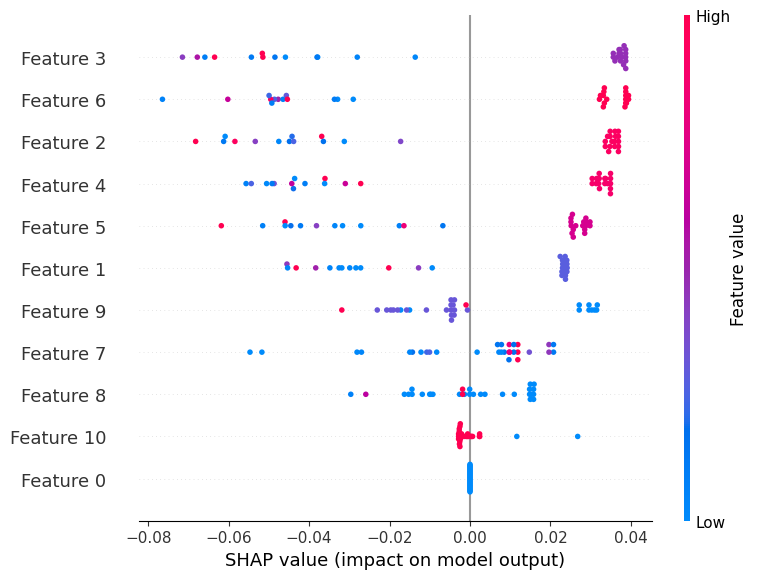

In [6]:
shap.initjs()
shap.summary_plot(shap_values[1], tokenized_input_ids)

### 5B. Assigning the sequence and position back to our features
- We need to retranslate the tokens back into sequences via DNABERT2 and can then graph with those. We can get the sequences by using the tokenizer from DNABERT2. We can get the position according to the position of the feature in the vector.
- Multiple GCGC - GCGC AND position
- [SEP] = end token or seperator
- [CLS] = start token for whole-sequence classification
- [PAD] = filler for short sequences

#### Why is the code below getting two token lists (tokens1 and tokens2)?
Each sequence might have different tokens. In this case I am just going to use the tokens found in the first input sequence for sake of ease. If I wanted to I could use ALL the tokens across all sequences by taking the union.

In [21]:
# Decode the token ids back to strings
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
print(len(tokenized_input_ids))
tokens1 = tokenizer.convert_ids_to_tokens(tokenized_input_ids[0].tolist())
tokens2 = tokenizer.convert_ids_to_tokens(tokenized_input_ids[1].tolist())

print(tokens1)  # You should now see actual tokens like 'ATG', 'GCGC', etc.
print(tokens2)

# Create a list of token positions
token_positions = [f"Position {idx}: {token}" for idx, token in enumerate(tokens1)]
print(token_positions)

30
['[CLS]', 'GCGC', 'GCGC', 'GCGC', 'GCGC', 'GCGC', 'GCGC', 'GCGCA', 'T', '[SEP]', '[PAD]']
['[CLS]', 'GCGC', 'GCGC', 'GCGC', 'GCGC', 'GCGC', 'GCGC', 'GCGCAA', '[SEP]', '[PAD]', '[PAD]']
['Position 0: [CLS]', 'Position 1: GCGC', 'Position 2: GCGC', 'Position 3: GCGC', 'Position 4: GCGC', 'Position 5: GCGC', 'Position 6: GCGC', 'Position 7: GCGCA', 'Position 8: T', 'Position 9: [SEP]', 'Position 10: [PAD]']


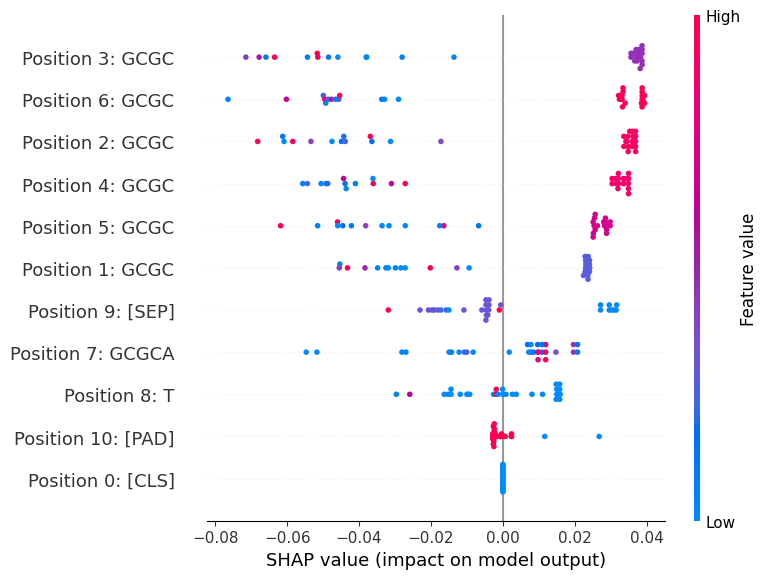

In [22]:
shap.summary_plot(shap_values[1], tokenized_input_ids, feature_names=token_positions)

### INTERPRETATION
* We see that a single GCGC is not enough to predict classification 1 and can sometimes lead to a classification of 0. This makes sense since I need a long stretch of GCs. Therefore, a BERT model using a longer kmer might have been better (I should be able to download that).
* The [] regions like [CLS] have little impact on results for the most part, which is expected.
* The feature value doesn't really matter as much in our case since we are considering tokens rather than numerical values.

## 2. Show versions used

In [19]:
!pip list

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Package                   Version
------------------------- --------------
accelerate                0.20.3
aiohappyeyeballs          2.4.4
aiohttp                   3.10.11
aiosignal                 1.3.1
antlr4-python3-runtime    4.9.3
anyio                     4.5.2
appnope                   0.1.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.4
async-timeout             5.0.1
attrs                     25.3.0
babel                     2.17.0
backcall                  0.2.0
beautifulsoup4            4.13.4
bleach                    6.1.0
certifi          

## 3. Fine Tuning on a p53 dataset
1. I'd expect the main trend captured to be the p53 motif